## Fitting z-values for MAQC mix ratio ##

From the [MAQC paper](http://www.nature.com.ezproxy.lib.utexas.edu/articles/nbt.2957#methods), it was suggested log2 fold change (lfc) bewteen samples C and D, and that between samples A and B can be used to find out how many RNAs were from sample A or sample B in the mixed samples usnig the following equation:

$$ log_2 \frac{C}{D} = log_2(k_1\frac{A}{B} + (1- k_1)) - log_2(k_2\frac{A}{B} + (1-k_2)) $$

where $k_1 = \frac{3z}{3z+1}$ and $k_2 = \frac{z}{z+3}$ 

To find *z* value, [nlrob](https://www.rdocumentation.org/packages/robustbase/versions/0.92-7/topics/nlrob) was used in MAQC/SEQC paper.

In [178]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import feather
import glob
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [229]:
def assign_prep(x):
    '''
    prep labeling
    '''
    if 'Conventional' in x:
        return 'HISAT2+featureCounts'
    elif 'Customized' in x:
        return 'TGIRT-map'
    else:
        return x

def get_predicted(z, AB):
    '''
    given z value and AB fold change,
    return predicted log CD fold change
    '''
    k1 = 3 * z / (3*z + 1)
    k2 = z / (z + 3)    
    A = np.log2(k1 * AB + (1-k1))
    B = np.log2(k2 * AB + (1-k2))
    return A - B
    
def optim_func(z, AB, log2_CD):
    '''
    wrapper for optimizer
    '''
    predicted = get_predicted(z, AB)
    return(mean_squared_error(log2_CD, predicted))

## Read table ##

In [211]:
project_path = '/stor/work/Lambowitz/cdw2854/bench_marking_new/bench_marking'
table_path = project_path + '/DEgenes'
tables = glob.glob(table_path + '/*.feather')
tables = filter(lambda x: not re.search('abundance|tpm|_[0-9]+|fc_table|aligned|bias',x), tables)

df = pd.concat(map(pd.read_feather, tables)) \
    .assign(map_type = lambda d: d['map_type'].map(assign_prep))\
    .assign(comparison = lambda d: d.comparison.str.replace(' vs ','')) \
    .assign(comparison = lambda d: 'log2_' + d.comparison) 
df.head()

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,comparison,map_type
0,18S_rRNA,17930.723136,-2.434074,0.291553,-8.348637,6.905499e-17,3.641780e-16,log2_AB,Kallisto
1,28S_rRNA,630646.766921,-1.741689,0.154609,-11.265115,1.950981e-29,1.469092e-28,log2_AB,Kallisto
2,5.8S_rRNA,2010.691276,-0.091213,0.421865,-0.216214,8.288207e-01,8.850579e-01,log2_AB,Kallisto
3,5S_rRNA,286.605627,-0.301691,0.274966,-1.097195,2.725564e-01,3.885457e-01,log2_AB,Kallisto
4,ENSG00000000003,717.464482,1.983906,0.124977,15.874186,9.564301e-57,1.224670e-55,log2_AB,Kallisto


In [212]:
expr_df  = df\
    .groupby(['id', 'map_type'], as_index=False)\
    .agg({'baseMean':'mean'})
expr_df.head()

,id,map_type,baseMean
0,18S_rRNA,HISAT2+featureCounts,229.104615
1,18S_rRNA,Kallisto,16573.558516
2,18S_rRNA,Salmon,56630.353467
3,18S_rRNA,TGIRT-map,17903.797278
4,28S_rRNA,HISAT2+featureCounts,33430.984647


In [226]:
fc_df = df\
    .filter(['id', 'comparison', 'map_type', 'log2FoldChange']) \
    .pipe(pd.pivot_table, 
          index = ['id','map_type'], 
          columns = 'comparison', 
          values = 'log2FoldChange', 
         dropna=True)\
    .reset_index() \
    .merge(expr_df, on =['id', 'map_type'], how = 'left')\
    .pipe(lambda d: d[(~(pd.isnull(d.log2_AB)) & (~pd.isnull(d.log2_CD)))]) \
    .assign(AB = lambda d: 2**d.log2_AB) \
    .pipe(lambda d: d[d.id.str.contains('ENSG')])   \
    .query('baseMean > 8')
fc_df.head()

,id,map_type,log2_AB,log2_CD,baseMean,AB
16,ENSG00000000003,HISAT2+featureCounts,1.906316,0.729928,582.976792,3.748507
17,ENSG00000000003,Kallisto,1.983906,0.665364,723.573159,3.955626
18,ENSG00000000003,Salmon,2.007145,0.719800,753.772850,4.019859
19,ENSG00000000003,TGIRT-map,1.921811,0.729241,582.623888,3.788983
20,ENSG00000000005,HISAT2+featureCounts,2.997168,0.930652,15.495031,7.984312


In [227]:
dfs = []
for map_type, map_d in fc_df.groupby('map_type'):
    opt = minimize(optim_func, 
         1, 
         (map_d.AB, map_d.log2_CD, ),
         bounds = ((0,5),)) 
    dfs.append(map_d \
                .assign(predicted = lambda d: get_predicted(opt.x[0], d.AB)) \
                .assign(map_type = lambda d: d.map_type + '\n$z$ = %.3f' %(opt.x[0]))
              )
    print('[%s] z-value: %.3f' %(map_type, opt.x))
pdf = pd.concat(dfs) \
    .assign(published = lambda d: get_predicted(1.43, d.AB)) 
pdf.head()

[HISAT2+featureCounts] z-value: 1.329
[Kallisto] z-value: 1.144
[Salmon] z-value: 1.118
[TGIRT-map] z-value: 1.320


,id,map_type,log2_AB,log2_CD,baseMean,AB,predicted,published
16,ENSG00000000003,HISAT2+featureCounts\n$z$ = 1.329,1.906316,0.729928,582.976792,3.748507,0.794144,0.774802
20,ENSG00000000005,HISAT2+featureCounts\n$z$ = 1.329,2.997168,0.930652,15.495031,7.984312,1.066123,1.033945
24,ENSG00000000419,HISAT2+featureCounts\n$z$ = 1.329,1.110602,0.506138,1711.476889,2.159357,0.506961,0.497570
28,ENSG00000000457,HISAT2+featureCounts\n$z$ = 1.329,-0.114612,-0.091280,764.431391,0.923630,-0.056660,-0.056226
32,ENSG00000000460,HISAT2+featureCounts\n$z$ = 1.329,1.625282,0.779203,1179.447866,3.085024,0.701341,0.685603


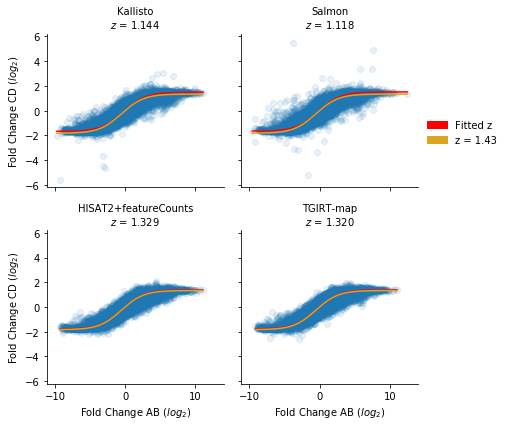

In [228]:
p = sns.FacetGrid(data = pdf.sort_values('log2_AB'), 
              col = 'map_type', 
              col_wrap = 2)
p.map(plt.scatter, 'log2_AB', 'log2_CD', alpha=0.1)
p.map(plt.plot, 'log2_AB', 'predicted', color = 'red')
p.map(plt.plot, 'log2_AB', 'published', color = 'goldenrod')
pat = [mpatches.Patch(color=col, label=lab) for col, lab in zip(['red','goldenrod'],['Fitted z', 'z = 1.43'])]
p.fig.axes[1].legend(handles=pat, 
                     bbox_to_anchor = (1,0.5),
                    frameon=False)
p.set_titles('{col_name}')
p.set_axis_labels('Fold Change AB ($log_2$)',
                 'Fold Change CD ($log_2$)')